# Hierarchical Modeling
What models fit the data?

# Setup

### Imports

In [1]:
# Stdlib imports
import json
import os
import re
import shutil

In [2]:
# Calculation imports
import cmdstanpy
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm, binned_statistic
from sklearn.metrics import root_mean_squared_error
import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [3]:
# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

### Parameters

In [4]:
config = {
    "bins": 16,
    "min_bin_percentile": 10,
    "nonden_fit_cols": ["references", "year"],
    "fit_dir": "../../analysis_data/stan_fits/stan_fit",
    "cat_col": "stan_field_code",
}

In [5]:
metrics = {
    r"$R^2$": sk_metrics.r2_score,
    "1-MAE": lambda y_true, y_pred: 1 - sk_metrics.mean_absolute_error(y_true, y_pred),
    "1-RMSE": lambda y_true, y_pred: 1
    - sk_metrics.root_mean_squared_error(y_true, y_pred),
    # "1-MAPE": lambda y_true, y_pred: 1
    # - sk_metrics.mean_absolute_percentage_error(y_true, y_pred),
    "1-MedAE": lambda y_true, y_pred: 1
    - sk_metrics.median_absolute_error(y_true, y_pred),
    "1-MPinL": lambda y_true, y_pred: 1 - sk_metrics.mean_pinball_loss(y_true, y_pred),
    r"$D^2_{pin}$": sk_metrics.d2_pinball_score,
    r"$D^2_{abs}$": sk_metrics.d2_absolute_error_score,
}

In [6]:
palette = sns.color_palette()

In [7]:
def log_sum_exp(mu):
    """Calculate the log sum of exponentials
    (pulling out the max to maintain) precision.
    """
    mu_max = np.max(mu)

    summation = np.sum(np.exp(mu - mu_max))
    return mu_max + np.log(summation)

In [8]:
def log_ppd(log_p):
    M = len(log_p)
    return -np.log(M) + log_sum_exp(log_p)

### Load data

In [9]:
df_all = pd.read_csv("../../analysis_data/all_data.csv")
df_all

,density,edginess,references,citations_per_year,is_center,identifier,year,librarian,vectorizer,center,fields_of_study_0
0,1545.550332,0.814415,42,2.250000,False,2e5f3e6c87d1676cdeffc3a2bfbc30b6cd06ed6f,2004,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
1,1846.261870,0.452021,88,4.625000,False,d7b6cd39dd111afa55a3aa418b7b5459db12988d,2012,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
2,1703.520959,0.490212,30,0.882353,False,2d62ec65f95435c72ef750b3cff331382c5dca92,2003,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
3,1901.386693,0.715160,95,8.166667,False,8cebc6e3dcfb543bad48d89112e281a6e11c33c2,2014,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
4,535.472125,0.885892,94,2.090909,False,59730a4bae4dc53f59341b63fd1e63451c589e9f,2009,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
...,...,...,...,...,...,...,...,...,...,...,...
537685,48.730838,0.658585,41,3.500000,False,806f77ba7bdf8a3b80cb859fb5f33f57c1d85d24,2018,S2,SciBERT,Andre2018,Mathematics
537686,25.107589,0.721374,38,3.200000,False,f40707d1165c22e185c25e6837977177ee380f2c,2015,S2,SciBERT,Andre2018,Mathematics
537687,41.647954,0.646499,11,1.529412,False,10636ee16779a7521001651164acb5c192d4ad7b,2003,S2,SciBERT,Andre2018,Mathematics
537688,35.738649,0.708053,15,2.384615,False,a229f829e0a5362d00e63781f687f40ede991635,2007,S2,SciBERT,Andre2018,Mathematics


In [10]:
# Basic nan handling across all obs
df_all["log_cpy"] = np.log10(df_all["citations_per_year"])
df_all["log_cpy"] = df_all["log_cpy"].replace(-np.inf, np.nan)

/Users/zhafen/miniconda3/envs/cmdstan/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
# Make the field category more useful
df_all["fields_of_study_0"] = df_all["fields_of_study_0"].astype("category")
df_all["stan_field_code"] = df_all["fields_of_study_0"].cat.codes + 1
field_names = df_all["fields_of_study_0"].cat.categories
field_names

Index(['Economics', 'Education', 'Geology', 'Linguistics', 'Materials Science',
       'Mathematics', 'Medicine', 'Philosophy', 'Physics'],
      dtype='object')

In [12]:
# Get the vectorizer names
vectorizer_names = sorted(df_all["vectorizer"].unique())
vectorizer_names

['BOW', 'GPT2', 'SBERT', 'SciBERT', 'Word2Vec']

In [13]:
# Get the columns we fit on
fit_cols = config["nonden_fit_cols"] + vectorizer_names

In [14]:
# Load the metadata
with open(f"{config["fit_dir"]}/metadata.json", "r") as json_file:
    metadata = json.load(json_file)

In [15]:
# Load raw data
models = [_ for _ in os.listdir(config["fit_dir"]) if os.path.isdir(f"{config["fit_dir"]}/{_}")]
draws = []
# Loop through models
for i, model_i in enumerate(models):
    model_dir_i = f"{config["fit_dir"]}/{model_i}"
    files_i = [_ for _ in os.listdir(model_dir_i) if _[-4:] == ".csv"]

    # Loop through chains per model
    draws_i = []
    for j, file_j in enumerate(files_i):
        chain_j = pd.read_csv(f"{model_dir_i}/{file_j}", comment="#")
        chain_j["chain"] = file_j.split(".")[0].split("_")[-1]
        draws_i.append(chain_j)
    draws_i = pd.concat(draws_i, ignore_index=True)

    # Get what csv columns match with what results columns
    beta_mapping = metadata[model_i]["beta_mapping"]
    if len(beta_mapping) > 0:
        # Frustratingly, the beta csvs don't save the same as the pandas output
        csv_beta_mapping = {}
        for draws_key, beta_key in beta_mapping.items():
            csv_key = draws_key.replace("[", ".").replace(",", ".").replace("]", "")
            csv_beta_mapping[csv_key] = beta_key
        draws_i = draws_i.rename(columns=csv_beta_mapping)

    # Store
    draws_i["model"] = model_i
    draws.append(draws_i)

draws = pd.concat(draws, ignore_index=True)
print(f"Draws df using {draws.memory_usage().sum() / (1024 ** 3):.3f} GB of memory")
draws

Draws df using 0.080 GB of memory


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,"beta[GPT2_j,Economics]",...,"beta[Word2Vec_j,Education]","beta[Word2Vec_j,Geology]","beta[Word2Vec_j,Linguistics]","beta[Word2Vec_j,Materials Science]","beta[Word2Vec_j,Mathematics]","beta[Word2Vec_j,Medicine]","beta[Word2Vec_j,Philosophy]","beta[Word2Vec_j,Physics]",mu_beta[Word2Vec_j],sigma_beta[Word2Vec_j]
0,-35763.0,0.966502,0.419373,3,7,0,35769.8,-0.009746,0.996053,0.088484,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-35764.5,0.886775,0.419373,3,7,0,35772.2,-0.008480,0.995333,0.086018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-35760.2,0.887315,0.419373,3,7,0,35775.0,-0.010535,0.999875,0.077112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-35762.8,0.943150,0.419373,3,7,0,35769.3,-0.011996,0.994637,0.066228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-35761.2,1.000000,0.419373,3,7,0,35767.1,-0.013339,0.995589,0.066493,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103995,-51483.5,0.701635,0.561654,2,3,0,51485.2,-0.004125,1.003170,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103996,-51482.4,0.979161,0.561654,2,3,0,51484.1,0.000210,1.002000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103997,-51484.6,0.699264,0.561654,2,3,0,51485.6,0.005945,1.002470,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103998,-51482.6,1.000000,0.561654,2,3,0,51484.5,0.001212,0.999576,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Load results, train, and test data
results = pd.read_csv(f"{config["fit_dir"]}/results.csv")
results = results.rename(columns={results.columns[0]: "model"})
df_train = pd.read_csv(f"{config["fit_dir"]}/train_data.csv", index_col=0)
df_test = pd.read_csv(f"{config["fit_dir"]}/test_data.csv", index_col=0)

# EDA

## Model Performance

In [17]:
performance = results.copy()

In [18]:
# List out the columns related to metrics
metric_cols = list(metrics.keys())
descaled_metric_cols = [f"{_}_descaled" for _ in metric_cols]
all_metric_cols = metric_cols + descaled_metric_cols

In [19]:
# Add scaled versions of metrics (go from min value(0) to max value(1))
# This is different form the "descaled" below, which refers to whether or not y_pred
# was returned to its unscaled version before the metric was calculated
metric_scaler = StandardScaler()
relative_performance = performance.copy()
relative_performance[all_metric_cols] = metric_scaler.fit_transform(
    X=performance[all_metric_cols]
)
relative_performance["metric_is_scaled"] = True
performance["metric_is_scaled"] = False
performance = pd.concat([performance, relative_performance], ignore_index=True)
performance

,model,alpha,beta[BOW],"beta[BOW_j,Economics]","beta[BOW_j,Education]","beta[BOW_j,Geology]","beta[BOW_j,Linguistics]","beta[BOW_j,Materials Science]","beta[BOW_j,Mathematics]","beta[BOW_j,Medicine]",...,$D^2_{abs}$,$R^2$_descaled,1-MAE_descaled,1-RMSE_descaled,1-MAPE_descaled,1-MedAE_descaled,1-MPinL_descaled,$D^2_{pin}$_descaled,$D^2_{abs}$_descaled,metric_is_scaled
0,base,-0.000435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.001631,-0.000003,0.467742,0.325609,-7.198579e+13,0.561933,0.733871,-0.001631,-0.001631,False
1,BOW,-0.016606,0.084467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000620,0.004861,0.468939,0.327251,-7.048048e+13,0.557623,0.734469,0.000620,0.000620,False
2,GPT2,-0.017009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.004737,0.013097,0.471126,0.330041,-6.941253e+13,0.562709,0.735563,0.004737,0.004737,False
3,SBERT,-0.001382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001034,0.001823,0.469158,0.326225,-7.186253e+13,0.562585,0.734579,0.001034,0.001034,False
4,SciBERT,-0.011637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.001614,0.000127,0.467751,0.325653,-7.106246e+13,0.558767,0.733876,-0.001614,-0.001614,False
5,Word2Vec,-0.015263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000967,0.001569,0.468095,0.326140,-7.093521e+13,0.558832,0.734047,-0.000967,-0.000967,False
6,nondens,-0.000385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.021030,0.038783,0.479784,0.338817,-7.856310e+13,0.572637,0.739892,0.021030,0.021030,False
7,BOW.nondens,-0.012504,0.063978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.025724,0.038433,0.482278,0.338697,-7.701933e+13,0.576286,0.741139,0.025724,0.025724,False
8,GPT2.nondens,-0.015566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.024565,0.048800,0.481662,0.342271,-7.566855e+13,0.571865,0.740831,0.024565,0.024565,False
9,SBERT.nondens,-0.001971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.021063,0.039173,0.479802,0.338951,-7.807653e+13,0.572672,0.739901,0.021063,0.021063,False


In [20]:
# Convert metrics into long format
nonmetric_cols = performance.columns.difference(pd.Series(all_metric_cols))
performance = performance.melt(
    id_vars=nonmetric_cols,
    var_name="metric_type",
    value_name="metric",
    ignore_index=False,
)
performance

,1-MAPE,1-MAPE_descaled,alpha,beta[BOW],"beta[BOW_j,Economics]","beta[BOW_j,Education]","beta[BOW_j,Geology]","beta[BOW_j,Linguistics]","beta[BOW_j,Materials Science]","beta[BOW_j,Mathematics]",...,sigma_beta[BOW_j],sigma_beta[GPT2_j],sigma_beta[SBERT_j],sigma_beta[SciBERT_j],sigma_beta[Word2Vec_j],sigma_beta[references_j],sigma_beta[year_j],y_col,metric_type,metric
0,-0.002011,-7.198579e+13,-0.000435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,log_cpy,$R^2$,-0.000003
1,-0.423401,-7.048048e+13,-0.016606,0.084467,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,log_cpy,$R^2$,0.004861
2,-0.689328,-6.941253e+13,-0.017009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,log_cpy,$R^2$,0.013097
3,-0.118944,-7.186253e+13,-0.001382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,log_cpy,$R^2$,0.001823
4,-0.179469,-7.106246e+13,-0.011637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,log_cpy,$R^2$,0.000127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,-0.614846,-6.638156e+13,0.003647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.045674,NaN,NaN,0.128865,0.083088,log_cpy_j,$D^2_{abs}$_descaled,1.157608
48,-0.618107,-6.520649e+13,-0.007284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.076395,NaN,0.129626,0.086709,log_cpy_j,$D^2_{abs}$_descaled,1.213414
49,-0.633112,-6.539763e+13,-0.006715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.045601,0.131825,0.077065,log_cpy_j,$D^2_{abs}$_descaled,1.171757
50,-0.683077,-6.484000e+13,-0.006733,NaN,-0.069030,-0.048171,-0.127076,-0.144772,-0.02482,-0.019750,...,0.052774,NaN,NaN,0.084819,NaN,0.134205,0.081525,log_cpy_j,$D^2_{abs}$_descaled,1.260076


In [21]:
# Split out the "descaled" into a separate column
performance["y_pred_is_scaled"] = ~performance["metric_type"].str.contains("_descaled")
performance["metric_type"] = performance["metric_type"].str.replace("_descaled", "")
performance

,1-MAPE,1-MAPE_descaled,alpha,beta[BOW],"beta[BOW_j,Economics]","beta[BOW_j,Education]","beta[BOW_j,Geology]","beta[BOW_j,Linguistics]","beta[BOW_j,Materials Science]","beta[BOW_j,Mathematics]",...,sigma_beta[GPT2_j],sigma_beta[SBERT_j],sigma_beta[SciBERT_j],sigma_beta[Word2Vec_j],sigma_beta[references_j],sigma_beta[year_j],y_col,metric_type,metric,y_pred_is_scaled
0,-0.002011,-7.198579e+13,-0.000435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,log_cpy,$R^2$,-0.000003,True
1,-0.423401,-7.048048e+13,-0.016606,0.084467,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,log_cpy,$R^2$,0.004861,True
2,-0.689328,-6.941253e+13,-0.017009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,log_cpy,$R^2$,0.013097,True
3,-0.118944,-7.186253e+13,-0.001382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,log_cpy,$R^2$,0.001823,True
4,-0.179469,-7.106246e+13,-0.011637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,log_cpy,$R^2$,0.000127,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,-0.614846,-6.638156e+13,0.003647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.045674,NaN,NaN,0.128865,0.083088,log_cpy_j,$D^2_{abs}$,1.157608,False
48,-0.618107,-6.520649e+13,-0.007284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.076395,NaN,0.129626,0.086709,log_cpy_j,$D^2_{abs}$,1.213414,False
49,-0.633112,-6.539763e+13,-0.006715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.045601,0.131825,0.077065,log_cpy_j,$D^2_{abs}$,1.171757,False
50,-0.683077,-6.484000e+13,-0.006733,NaN,-0.069030,-0.048171,-0.127076,-0.144772,-0.02482,-0.019750,...,NaN,NaN,0.084819,NaN,0.134205,0.081525,log_cpy_j,$D^2_{abs}$,1.260076,False


<Axes: xlabel='metric', ylabel='metric_type'>

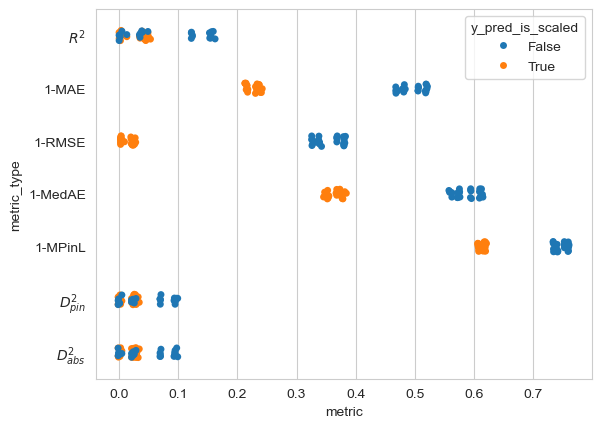

In [22]:
# Typical ranges for metrics
sns.stripplot(
    data=performance.query("metric_is_scaled == False"),
    x="metric",
    y="metric_type",
    hue="y_pred_is_scaled",
)

<Axes: xlabel='metric', ylabel='metric_type'>

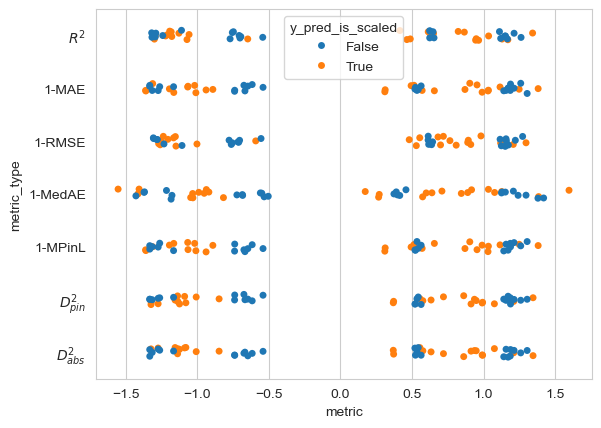

In [23]:
# Performance for metrics scaled by their mean and std
sns.stripplot(
    data=performance.query("metric_is_scaled == True"),
    x="metric",
    y="metric_type",
    hue="y_pred_is_scaled",
)

This is clearly more informative than the original unscaled metrics.

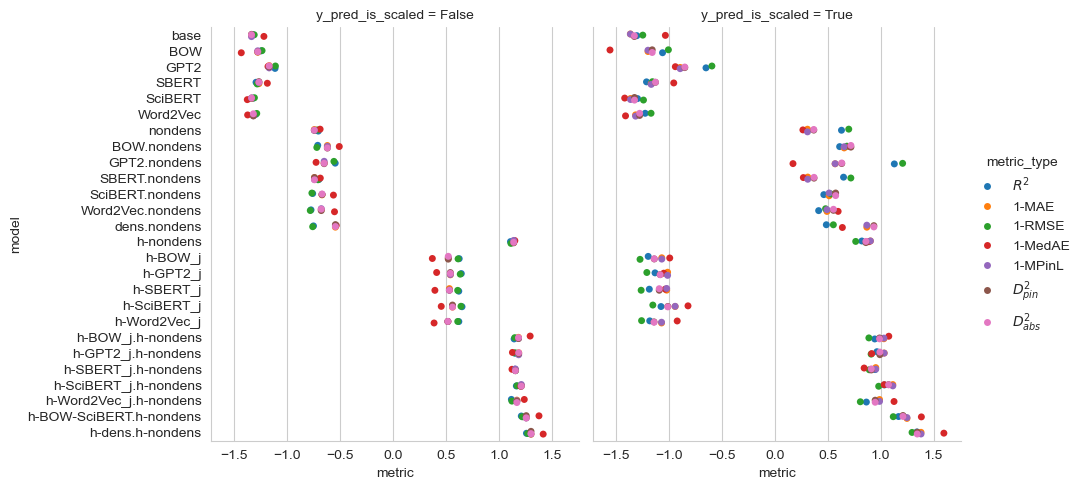

In [24]:
sns.catplot(
    data=performance.query("metric_is_scaled == True"),
    x="metric",
    y="model",
    col="y_pred_is_scaled",
    hue="metric_type",
)

This shows that the hierarchical models pretty clearly outperform the other models, with hierarchical on all densities and non-densities performing the highest.
In order for a model to perform well, it must include the references and year dependence in some form.
With the above in mind, we'll consider all models that include a per-field dependence on non-density variables to be "good".

In [25]:
results["is_good_model"] = results["model"].str.contains("h-nondens")
selected_results = results.query("is_good_model==True")
good_models = selected_results["model"]

## Coefficients

Now that we have isolated our good models, let's look at the coefficients of the regression.

### Coefficients for Well-Performing Models

In [26]:
def melt_betas(
    df: pd.DataFrame,
    merge_cols = ["model", "beta_type"],
):
    '''Melt betas into a new dataframe.
    Making a function because we'll also apply it to draws
    '''

    # Different types of columns
    beta_cols = [_ for _ in df.columns if _[:5] == "beta["]
    nonbeta_cols = [_ for _ in df.columns if "beta" not in _]
    mubeta_cols = [_ for _ in df.columns if "mu_beta" in _]
    sigmabeta_cols = [_ for _ in df.columns if "sigma_beta" in _]

    # We look only at the good models
    betas = df.melt(
        id_vars=nonbeta_cols,
        value_vars=beta_cols,
        var_name="beta_type",
        value_name="beta",
        ignore_index=False,
    )

    # Get the field and variable out of the beta name
    beta_vars = betas["beta_type"].str.findall(r"beta\[(.*)\]").str[0]
    betas["field"] = beta_vars.str.findall(r"\,(.*)").str[0]
    betas["field"] = betas["field"].fillna("All")
    betas["variable"] = beta_vars.str.split(",").str[0]

    # Add in the mu_betas, since those are mean betas
    mubetas = df.melt(
        id_vars=nonbeta_cols,
        value_vars=mubeta_cols,
        var_name="beta_type",
        value_name="beta",
        ignore_index=False,
    )
    mubetas["variable"] = mubetas["beta_type"].str.findall(r"mu_beta\[(.*)\]").str[0]
    mubetas["field"] = "All"

    # Grab the sigmabetas
    sigmabetas = df.melt(
        value_vars=sigmabeta_cols,
        id_vars=pd.Index(merge_cols).difference(["beta_type"]),
        var_name="beta_type",
        value_name="sigma_beta",
    )
    sigmabetas["beta_type"] = sigmabetas["beta_type"].str.replace("sigma", "mu")

    # Join
    mubetas = mubetas.merge(
        sigmabetas,
        on=merge_cols,
        validate="one_to_one",
    )

    # Combine and clean up
    betas = pd.concat([betas, mubetas], ignore_index=True)
    betas["variable"] = betas["variable"].str.replace("_j", "").astype("category")
    betas["field"] = betas["field"].astype("category")

    return betas

In [27]:
betas = melt_betas(selected_results)

<Axes: xlabel='beta', ylabel='Count'>

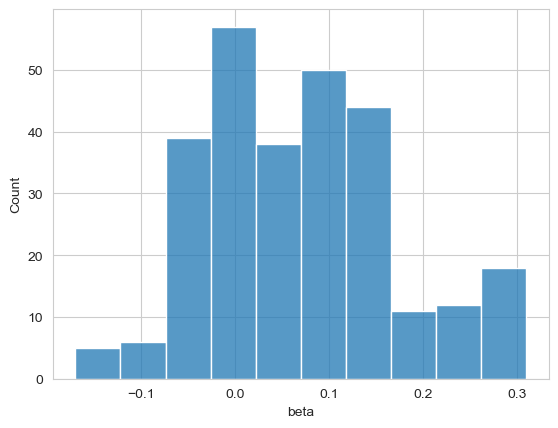

In [28]:
# Get an overview of the range of possible correlations
sns.histplot(betas["beta"])

In [29]:
# Now that we've looked at the non-na values, we turn those into zeros
betas["beta"] = betas["beta"].fillna(value=0.0)

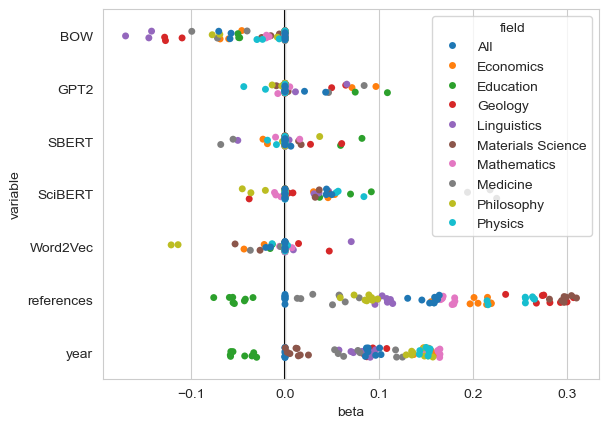

In [30]:
# Look at betas per variable
fig = plt.figure()
ax = plt.gca()

sns.stripplot(
    ax=ax,
    data=betas,
    x="beta",
    y="variable",
    hue="field",
)

ax.axvline(
    0,
    color="k",
    zorder=-1,
)

This places decent constraints on what the coefficients should be across a range of models

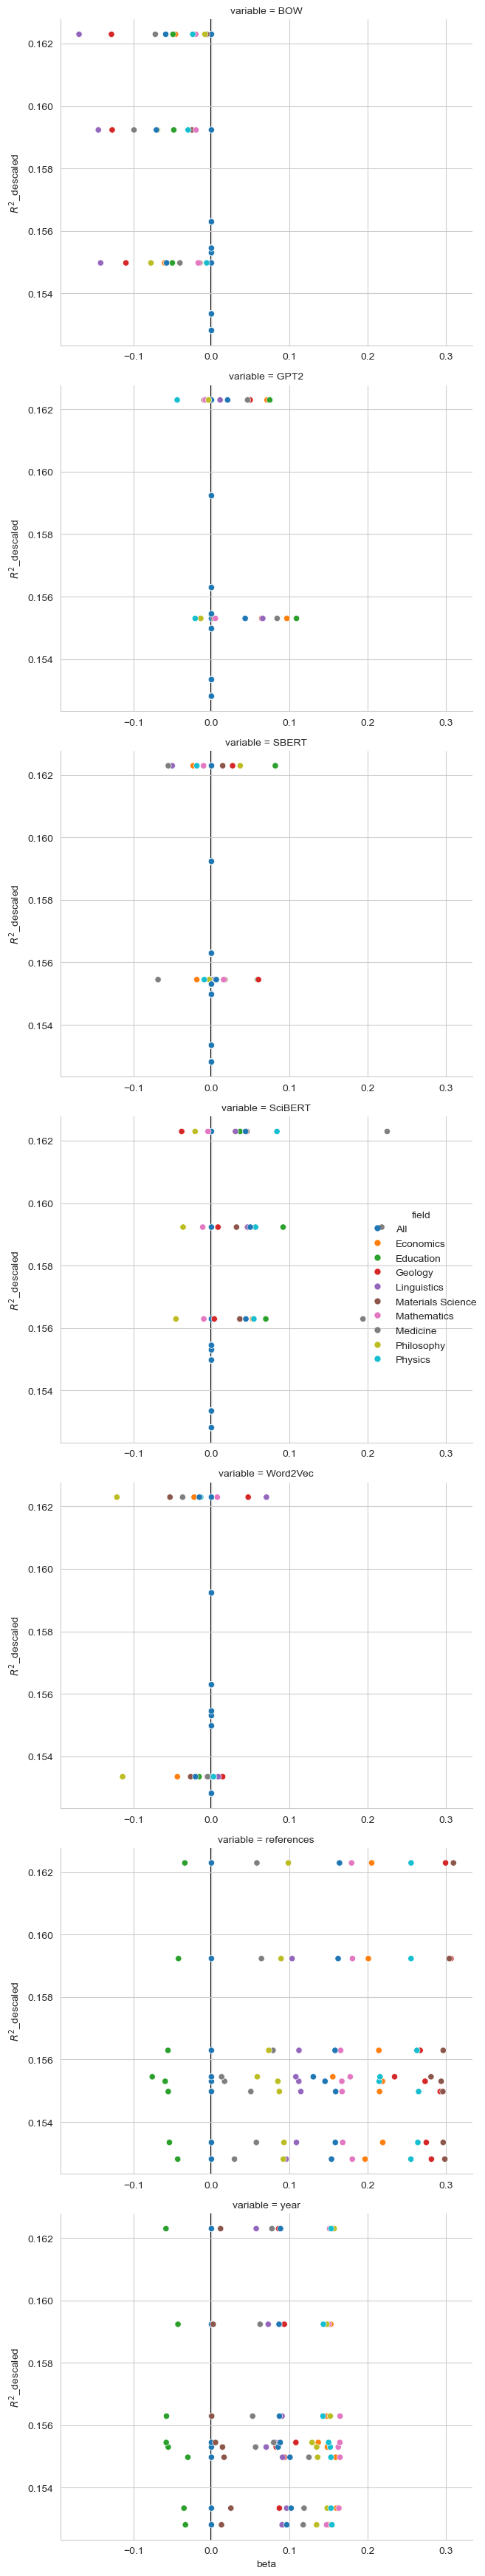

In [31]:
# Same plot as above, but with a y-axis that shows model performance
fg = sns.relplot(
    data=betas,
    x="beta",
    y=r"$R^2$_descaled",
    row="variable",
    hue="field",
)

for row in fg.axes:
    ax = row[0]

    ax.axvline(
        0,
        color="k",
        zorder=-1,
    )
    ax.tick_params(labelbottom=True)

plt.tight_layout()

These plots confirm, by showing that betas don't strongly depend on performance, within the good models.

### Coefficients for the Best Model

In [32]:
# Let's focus on our best model, h-dens.h-nondens
best_model = betas.iloc[betas["$R^2$_descaled"].argmax()]["model"]
assert (
    best_model == "h-dens.h-nondens"
), "The best model is no longer h-dens.h-nondens. Following analysis should be treated with caution."

In [33]:
# Select the best model and the relevant columns
best_betas = betas.query(f"model == '{best_model}'")
assert (
    best_betas["beta_type"].unique().size == best_betas["beta_type"].size
), "Each row does not correspond to a different beta_type"

In [34]:
# Drop the betas that aren't evaluated in hierarchical modeling
is_hierarchical = best_betas["beta_type"].str.contains("_j")
best_betas = best_betas.loc[is_hierarchical]

In [35]:
# Select only the columns that can differ for beta
beta_unique_cols = ["beta_type", "beta", "field", "variable", "sigma_beta"]
best_betas = best_betas[beta_unique_cols]
best_betas

,beta_type,beta,field,variable,sigma_beta
15,"beta[BOW_j,Economics]",-0.045987,Economics,BOW,NaN
23,"beta[BOW_j,Education]",-0.049207,Education,BOW,NaN
31,"beta[BOW_j,Geology]",-0.127977,Geology,BOW,NaN
39,"beta[BOW_j,Linguistics]",-0.169513,Linguistics,BOW,NaN
47,"beta[BOW_j,Materials Science]",-0.006010,Materials Science,BOW,NaN
...,...,...,...,...,...
583,mu_beta[SBERT_j],0.000154,All,SBERT,0.057249
591,mu_beta[SciBERT_j],0.043752,All,SciBERT,0.088719
599,mu_beta[Word2Vec_j],-0.015392,All,Word2Vec,0.065656
607,mu_beta[references_j],0.164024,All,references,0.132771


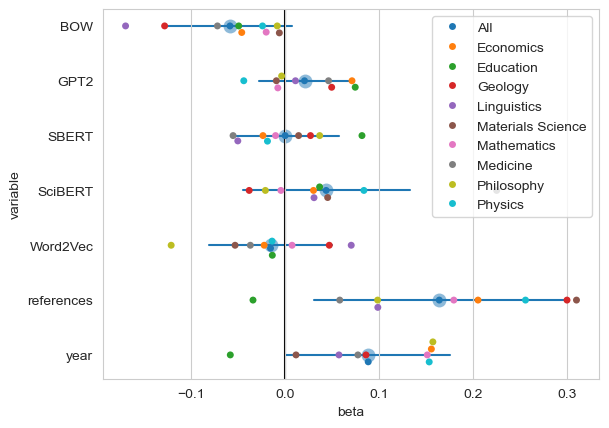

In [36]:
# Betas per field
ax = sns.swarmplot(
    data=best_betas,
    x="beta",
    y="variable",
    hue="field",
)
# mu_betas
ax = sns.swarmplot(
    ax=ax,
    data=best_betas.query("field == 'All'"),
    x="beta",
    y="variable",
    size=10,
    color=palette[0],
    zorder=-1,
    alpha=0.5,
)

# Loop through and add sigmas
variables = [_.get_text() for _ in ax.get_yticklabels()]
variable_ys = ax.get_yticks()
for i, variable_i in enumerate(variables):
    # Get the right row
    row = best_betas.query(
        f"variable == '{variable_i}' & field == 'All'",
    )

    # Plot a line
    ax.plot(
        [row["beta"] - row["sigma_beta"], row["beta"] + row["sigma_beta"]],
        [variable_ys[i], variable_ys[i]],
        color=palette[0],
        zorder=-1,
    )

# Add a guiding line
ax.axvline(
    0,
    color="k",
    zorder=-1,
)

The value in the back with the bar is the mean and std for the distribution the betas come from,
according to the fit model.

This gives us a good overview of how everything fits, but the above values are just the best-fit parameter.
We need to understand how much variability there is per field, per variable.

In [37]:
# Only include the columns that are also in results, i.e. we can do something with them
best_draws = draws.query(f"model == '{best_model}'")
best_draws = best_draws.drop(columns=best_draws.columns.difference(results.columns))

In [38]:
# Melt into long format
# We reset the index and merge on it so each draw has a unique identifier
best_draws = melt_betas(
    best_draws.reset_index(),
    merge_cols=["index", "beta_type"]
)
best_draws

,index,alpha,sigma,model,beta_type,beta,field,variable,sigma_beta
0,96000,-0.002321,0.964582,h-dens.h-nondens,"beta[GPT2_j,Economics]",0.081260,Economics,GPT2,NaN
1,96001,-0.015757,0.965621,h-dens.h-nondens,"beta[GPT2_j,Economics]",0.086490,Economics,GPT2,NaN
2,96002,-0.004367,0.960534,h-dens.h-nondens,"beta[GPT2_j,Economics]",0.071335,Economics,GPT2,NaN
3,96003,-0.007426,0.962084,h-dens.h-nondens,"beta[GPT2_j,Economics]",0.083040,Economics,GPT2,NaN
4,96004,-0.014531,0.963633,h-dens.h-nondens,"beta[GPT2_j,Economics]",0.051901,Economics,GPT2,NaN
...,...,...,...,...,...,...,...,...,...
307995,99995,-0.016156,0.966037,h-dens.h-nondens,mu_beta[Word2Vec_j],-0.024457,All,Word2Vec,0.059072
307996,99996,-0.000230,0.963393,h-dens.h-nondens,mu_beta[Word2Vec_j],-0.011996,All,Word2Vec,0.055076
307997,99997,0.002950,0.962627,h-dens.h-nondens,mu_beta[Word2Vec_j],-0.005687,All,Word2Vec,0.037489
307998,99998,-0.020573,0.960881,h-dens.h-nondens,mu_beta[Word2Vec_j],0.007840,All,Word2Vec,0.074730


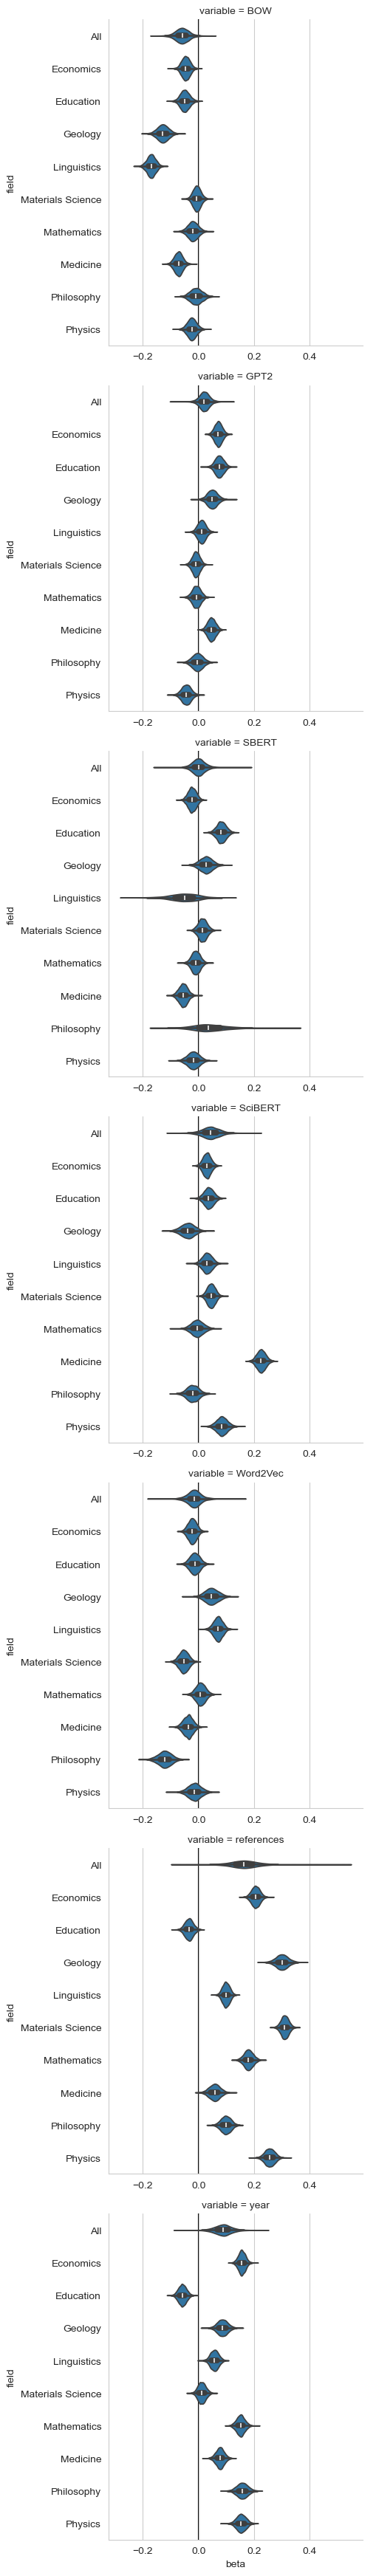

In [39]:
# Look at how the betas change across fields,
# including how much variability there is in that
fg = sns.catplot(
    data=best_draws,
    x="beta",
    y="field",
    row="variable",
    kind="violin",
)
for row in fg.axes:
    ax = row[0]

    ax.axvline(
        0,
        color="k",
        zorder=-1,
    )
    ax.tick_params(labelbottom=True)

plt.tight_layout()

### Coefficient distributions for multiple models

In [40]:
good_draws = draws.query(f"model in {list(good_models)}")

In [41]:
# Only include the columns that are also in results, i.e. we can do something with them
good_draws = good_draws.drop(columns=good_draws.columns.difference(results.columns))

In [42]:
# Melt into long format
# We reset the index and merge on it so each draw has a unique identifier
good_draws = melt_betas(
    good_draws.reset_index(),
    merge_cols=["index", "beta_type"]
)
good_draws

,index,alpha,sigma,model,beta_type,beta,field,variable,sigma_beta
0,12000,-0.003356,0.968377,h-GPT2_j.h-nondens,"beta[GPT2_j,Economics]",0.086614,Economics,GPT2,NaN
1,12001,-0.005918,0.975443,h-GPT2_j.h-nondens,"beta[GPT2_j,Economics]",0.114203,Economics,GPT2,NaN
2,12002,-0.006459,0.974271,h-GPT2_j.h-nondens,"beta[GPT2_j,Economics]",0.105342,Economics,GPT2,NaN
3,12003,-0.002894,0.970180,h-GPT2_j.h-nondens,"beta[GPT2_j,Economics]",0.100728,Economics,GPT2,NaN
4,12004,-0.010590,0.974231,h-GPT2_j.h-nondens,"beta[GPT2_j,Economics]",0.097913,Economics,GPT2,NaN
...,...,...,...,...,...,...,...,...,...
2463995,99995,-0.016156,0.966037,h-dens.h-nondens,mu_beta[Word2Vec_j],-0.024457,All,Word2Vec,0.059072
2463996,99996,-0.000230,0.963393,h-dens.h-nondens,mu_beta[Word2Vec_j],-0.011996,All,Word2Vec,0.055076
2463997,99997,0.002950,0.962627,h-dens.h-nondens,mu_beta[Word2Vec_j],-0.005687,All,Word2Vec,0.037489
2463998,99998,-0.020573,0.960881,h-dens.h-nondens,mu_beta[Word2Vec_j],0.007840,All,Word2Vec,0.074730


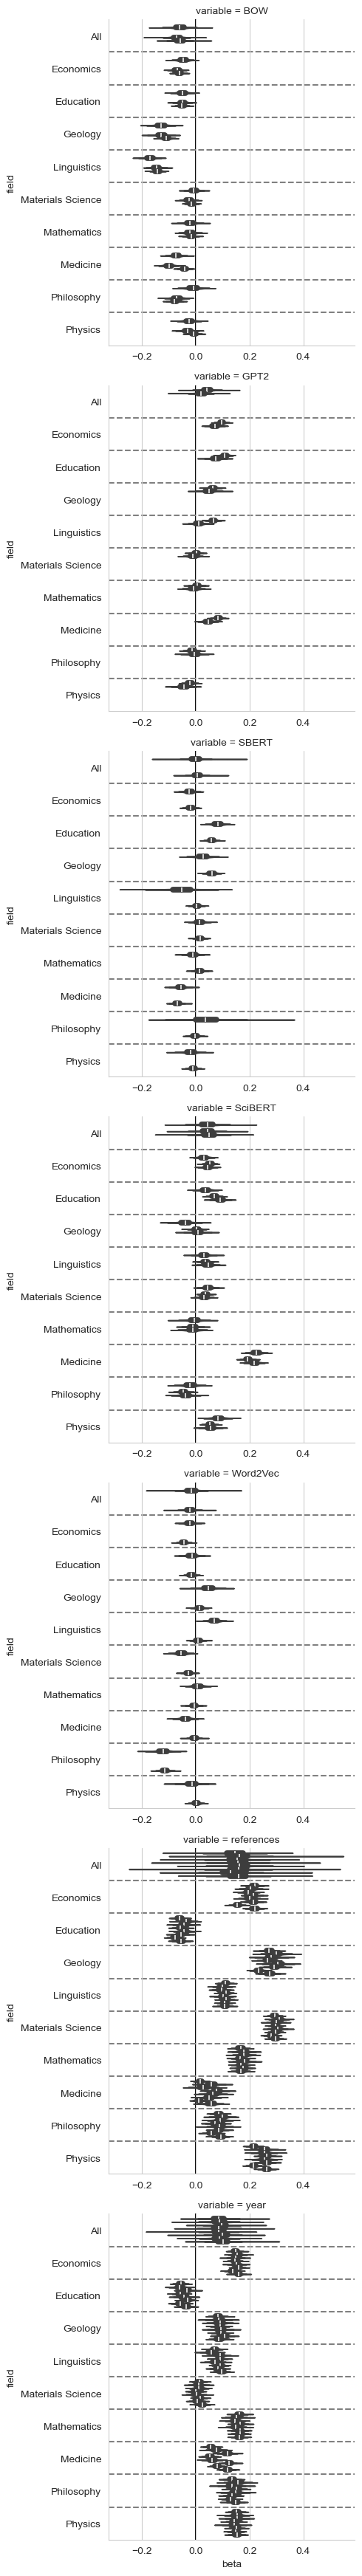

In [43]:
# Look at how the betas change across fields,
# including how much variability there is in that
fg = sns.catplot(
    data=good_draws.dropna(subset=["beta"]),
    x="beta",
    y="field",
    row="variable",
    kind="violin",
    hue="model",
    legend=None,
)
for row in fg.axes:
    ax = row[0]

    ax.axvline(
        0,
        color="k",
        zorder=-1,
    )
    ax.tick_params(labelbottom=True)
    
    for y_tick in ax.get_yticks()[:-1]:
        ax.axhline(
            y_tick + 0.5,
            color=".5",
            zorder=-1,
            linestyle='--',
        )

plt.tight_layout()